In [1]:
import pandas as pd


In [2]:
tweets=pd.read_excel('treatment_tweets_new.xlsx')

In [16]:
tweets['Sentiment']=tweets['Sentiment'].replace('Positive',0)
tweets['Sentiment']=tweets['Sentiment'].replace('Negative',1)
tweets.content = tweets['content'].fillna("")
tweets.text_process = tweets['text_process'].fillna("")
tweets.head()

,handle,name,content,replies,retweets,favorites,published_date,text_process,Sentiment,Tweet
0,@AmberLyon,Amber Lyon,Psychedelic #Mushrooms Could Be The Next Break...,2.0,55,52,12:12 PM - 27 Dec 2015,psychedelic mushrooms could next breakthrough ...,1,psychedelic mushrooms could next breakthrough ...
1,@ThePaintedBrain,Painted Brain LA,Talking to loved ones about #depression allevi...,NaN,15,22,2:55 PM - 11 Feb 2018,talking loved ones depression alleviates press...,1,talking loved ones depression alleviates press...
2,@Medscape,Medscape,FDA panels vote to recommend approval of esket...,1.0,14,23,11:09 AM - 13 Feb 2019,fda panels vote recommend approval esketamine ...,1,fda panels vote recommend approval esketamine ...
3,@CHarrisBond,Courtenay HarrisBond,I am eager and anxious to be trying a course o...,2.0,3,20,7:43 AM - 26 Dec 2017,eager anxious trying course transcranial magne...,1,eager anxious trying course transcranial magne...
4,@NAMICommunicate,NAMI,I lived w/ #depression for 6 years before seek...,NaN,13,31,6:00 PM - 7 Sep 2016,lived w depression years seeking treatment den...,1,lived w depression years seeking treatment den...


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit((tweets.text_process).apply(lambda x: np.str_(x)))
vectorizer.vocabulary_
vectorizer.transform((tweets.text_process).apply(lambda x: np.str_(x))).toarray()
vectorizer.fit(tweets.Tweet.apply(lambda x: np.str_(x)))

#x = v.fit_transform(df['Review'].apply(lambda x: np.str_(x)))

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=False, max_df=1.0, max_features=None, min_df=0,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [19]:
from sklearn.model_selection import train_test_split
import numpy as np

sentences = tweets['text_process'].values
y = tweets['Sentiment'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2, random_state=1000)

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train.astype('U'))
#X_train = vectorizer.fit_transform(sentences_train.apply(lambda x: np.str_(x)))

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train



<691x3086 sparse matrix of type '<type 'numpy.int64'>'
	with 8282 stored elements in Compressed Sparse Row format>

In [20]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

('Accuracy:', 0.9075144508670521)


/Users/sriramswa/anaconda3/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
classifier.score(X_train, y_train)

0.9927641099855282

In [22]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

physicians recommended cannabis treatment depression since httpmmjnewsthw pictwittercomuzghsft
[69, 70, 28, 2, 1, 53, 61, 896]


In [23]:
for word in ['medical', 'happy', 'sad']:print('{}: {}'.format(word, tokenizer.word_index[word]))

medical: 81
happy: 315
sad: 342


In [24]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_train.shape

(691, 100)

In [25]:
type(X_train)

numpy.ndarray

In [26]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           154950    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 204,971
Trainable params: 204,971
Non-trainable params: 0
_________________________________________________________________


In [27]:
import numpy as np
history = model.fit((X_train), (y_train),
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)


Instructions for updating:
Use tf.cast instead.


In [29]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Training Accuracy: 1.0000
Testing Accuracy:  0.9017


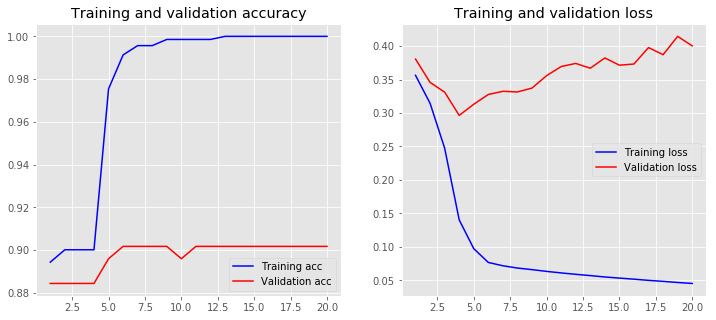

In [30]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

(2116,)

In [39]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           189400    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 189,921
Trainable params: 189,921
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.9208


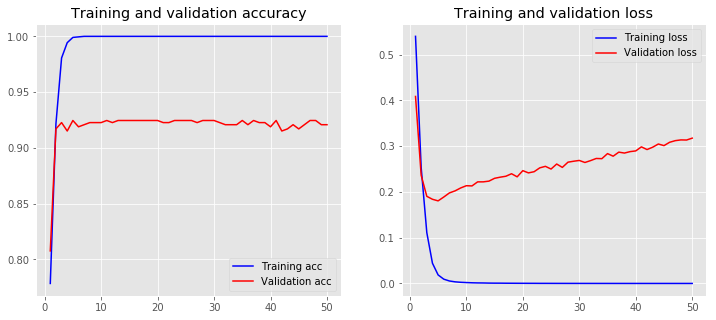

In [40]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [41]:
#CNN

embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          378800    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 444,229
Trainable params: 444,229
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.9283


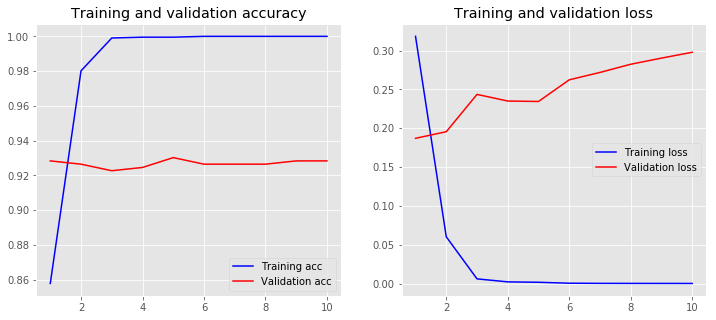

In [42]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)